In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!unzip '/content/drive/My Drive/DATASETS/intel-image-classification.zip' -d 'intel-image-classification/'


Archive:  /content/drive/My Drive/DATASETS/intel-image-classification.zip
  inflating: intel-image-classification/seg_train.zip  
  inflating: intel-image-classification/seg_test.zip  
  inflating: intel-image-classification/seg_pred.zip  


In [0]:
!unzip 'intel-image-classification/seg_train.zip' -d 'intel-image-classification/seg_train/'
!unzip 'intel-image-classification/seg_test.zip' -d 'intel-image-classification/seg_test/'
!unzip 'intel-image-classification/seg_pred.zip' -d 'intel-image-classification/seg_pred/'

In [0]:
import keras
from keras.utils import to_categorical
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf


from keras.models import Model

from keras.utils import plot_model

import warnings
#warnings.warn("ignore")
import os

Using TensorFlow backend.


In [0]:
#!unzip 'intel-image-classification.zip'

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_width, image_height = 150,150

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
)

test_datagen = ImageDataGenerator( rescale = 1./255. )

train_generator = train_datagen.flow_from_directory(
                    "intel-image-classification/seg_train/seg_train/",
                    batch_size=128,
                    class_mode='categorical',
                    target_size=(image_width, image_height)
)     

test_generator =  test_datagen.flow_from_directory(
                    "intel-image-classification/seg_test/seg_test/",
                    batch_size=128, 
                    class_mode='categorical',
                    target_size=(image_width, image_height)
)


Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [0]:
def inception_module(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
    # 1x1 conv
    conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
    # 3x3 conv
    conv3 = Conv2D(f2_in, (1,1), padding='same', activation='relu')(layer_in)
    conv3 = Conv2D(f2_out, (3,3), padding='same', activation='relu')(conv3)
    # 5x5 conv
    conv5 = Conv2D(f3_in, (1,1), padding='same', activation='relu')(layer_in)
    conv5 = Conv2D(f3_out, (5,5), padding='same', activation='relu')(conv5)
    # 3x3 max pooling
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
    pool = Conv2D(f4_out, (1,1), padding='same', activation='relu')(pool)
    # concatenate filters, assumes filters/channels last
    layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
    return layer_out

In [0]:
def identity_block(X, f, filters, stage, block):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value. We'll need this later to add back to the main path. 
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X


In [0]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X
    

    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    
    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [0]:
def DeepResNetInception(input_shape = (150, 150, 3), classes = 6):   
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

   
    # Zero-Padding
    #X = ZeroPadding2D((3, 3))(X_input)
    X = X_input
    
    keep_prob = .25
    # Stage 1
    X = Conv2D(16, (3, 3), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = Dropout(keep_prob)(X)
    X = Activation('relu')(X)

    # Stage 2
    X = Conv2D(32, (3, 3), strides = (2, 2), name = 'conv2', kernel_initializer = glorot_uniform(seed=0))(X)
    X = Dropout(keep_prob)(X)
    X = Activation('relu')(X)

    
    # Stage 3
    X = Conv2D(64, (3, 3), strides = (2, 2), name = 'conv3', kernel_initializer = glorot_uniform(seed=0))(X)
    X = Dropout(keep_prob)(X)
    X = Activation('relu')(X)
       

    # inception module (out 128)
    X = inception_module(X, f1=32, f2_in=(32+8), f2_out=64, f3_in=8, f3_out=16, f4_out=16)
    X = Dropout(keep_prob)(X)
    X = Activation('relu')(X)    

    # Stage 5
    X = convolutional_block(X, f = 3, filters = [128, 128, 256], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 256], stage=4, block='b')
    X = Dropout(keep_prob)(X)
    X = Activation('relu')(X)    
    
    # inception module (out 256)
    X = inception_module(X, f1=64, f2_in=(64+16), f2_out=128, f3_in=16, f3_out=32, f4_out=32)
    X = Dropout(keep_prob)(X)
    X = Activation('relu')(X)    

    # Stage 5
    X = convolutional_block(X, f = 3, filters = [256, 128, 512], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 512], stage=5, block='b')
    X = Dropout(keep_prob)(X)
    X = Activation('relu')(X)
    
    # inception module (out 512)
    X = inception_module(X, f1=128, f2_in=(128+32), f2_out=256, f3_in=32, f3_out=64, f4_out=64)
    X = Dropout(keep_prob)(X)
    X = Activation('relu')(X)    

    # Stage 5
    X = convolutional_block(X, f = 3, filters = [512, 512, 1024], stage = 6, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 1024], stage=6, block='b')
    X = Dropout(keep_prob)(X)
    X = Activation('relu')(X)    



    # AVGPOOL
    X = AveragePooling2D((2, 2), name='avg_pool')(X)

    # output layer
    X = Flatten()(X)
    X = Dropout(keep_prob)(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes),  kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='DeepRes-ception')

    return model


In [0]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import cv2
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Dropout, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import keras.backend as K
import tensorflow as tf

from keras.layers.merge import concatenate

In [0]:
img_shape = (150, 150, 3)
model = DeepResNetInception(input_shape=img_shape, classes=6)



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [0]:
#model.load_weights("Deep-Res-ception-v8_weights.h5")

In [0]:
model.summary()


Model: "DeepRes-ception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 74, 74, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 74, 74, 16)   0           conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 74, 74, 16)   0           dropout_1[0][0]                  
____________________________________________________________________________________

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [0]:
#model.load_weights("Deep-Res-ception-v8_weights.h5")

In [0]:
# fits the model on batches with real-time data augmentation:
trained_model = model.fit_generator(
            train_generator,
            validation_data=test_generator,
            epochs=25
)

#trained_model = model.fit_generator(datagen.flow(X_train, y_train, batch_size=64),
#                    steps_per_epoch=len(X_train) / 64, epochs=25, validation_data=(X_test, y_test), use_multiprocessing = False)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/25
110/110 [==============================] - 109s 995ms/step - loss: 1.8135 - acc: 0.3472 - val_loss: 2.4898 - val_acc: 0.1940
Epoch 2/25
110/110 [==============================] - 97s 878ms/step - loss: 1.1958 - acc: 0.5236 - val_loss: 1.8497 - val_acc: 0.3587
Epoch 3/25
110/110 [==============================] - 97s 883ms/step - loss: 1.0357 - acc: 0.5920 - val_loss: 1.1855 - val_acc: 0.5577
Epoch 4/25
110/110 [==============================] - 97s 882ms/step - loss: 0.9476 - acc: 0.6372 - val_loss: 1.0576 - val_acc: 0.5910
Epoch 5/25
110/110 [==============================] - 97s 883ms/step - loss: 0.8990 - acc: 0.6596 - val_loss: 1.2567 - val_acc: 0.5577
Epoch 6/25
110/110 [==============================] - 97s 884ms/step - loss: 0.8451 - acc: 0.6852 - val_loss: 1.3032 - val_acc: 0.5530
Epoch 7/25
110/110 [==============================] - 97s 881ms/step - loss: 0.8019 - acc: 0.70

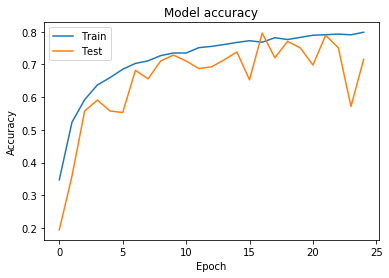

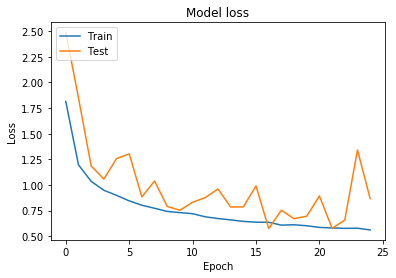

In [0]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(trained_model.history['acc'])
plt.plot(trained_model.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
model.evaluate_generator(test_generator)


[0.8661104936599732, 0.715666666984558]

In [0]:
model.save_weights('Deep-Res-ception_v3_with_da_weights.h5')

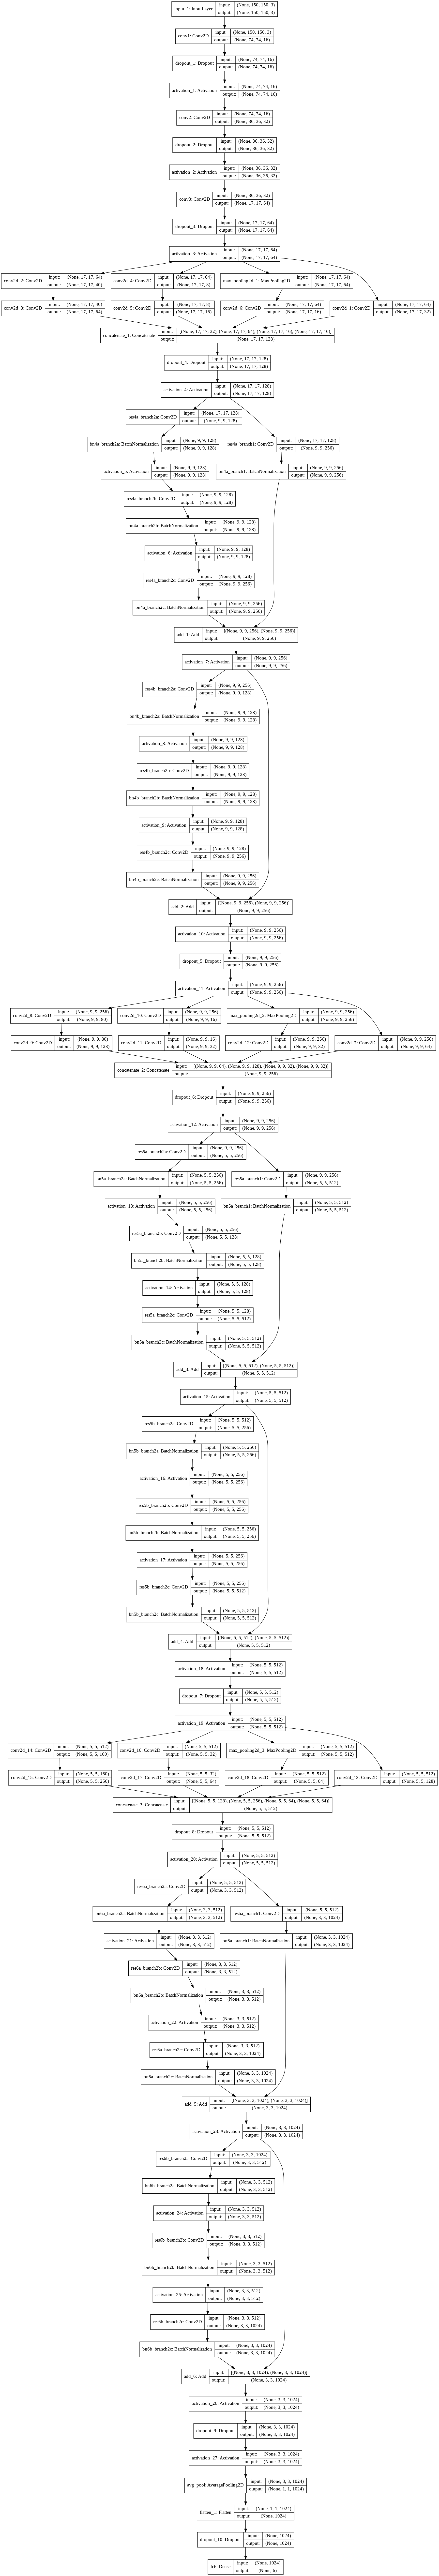

In [0]:
plot_model(model, show_shapes=True, to_file='Deep-Res-Inception-V3.png')